<center>
    <img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" style="width:60%">
    <h1> INF285 - Computación Científica </h1>
    <h2> Tarea 2</h2>
    <h2> [S]cientific [C]omputing [T]eam </a> </h2>
    <h2> Version: 1.00</h2>
</center>

# Contexto

Los patrones de fractura aparecen en distintos campos desde la geología a la ciencia de materiales. A veces el foco está puesto en la forma de la fractura misma, pero otros investigadores están interesados en indicadores que permiten mostrar el comportamiento del patrón. Por ejemplo, la distribución de las áreas de cada celda, la distribución de los perímetros de cada celda, o la densidad del patrón, la cual consiste en conocer el porcentaje de "fracturas" presentes en el patrón versus el dominio. Cuando todas las imágenes obtenidas tienen la misma dimensión no es un problema poder trabajar con ellas, pero cuando tienen tamaño distinto entre ellas puede ser catastrófico. 

El objetivo de la tarea es poder evaluar dos procedimientos que permitan trabajar con imágenes de patrones de fractura considerando que tienen distinto tamaño entre ellas. Para esta tarea usted cuenta con la carpeta $\verb|img|$ donde se encuentran $6000$ imágenes a su disposición, así como también se cuenta con el archivo $\verb|SIZE_IMG.npy|$ el cual contiene la información sobre las dimensiones de cada imagen.

A continuación se entrega una serie de funciones y variables a utilizar en esta tarea.

## Librerías, variables y funciones predefinidas (NO MODIFICAR)

In [2]:
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BarycentricInterpolator

In [35]:
def chebyshev_points(N):
    return np.cos((2*np.arange(1, N+1) - 1) * np.pi / (2*N))

def interpolateLog(n):
    x_cheb = chebyshev_points(n)
    y = np.exp(x_cheb)
    pLog = BarycentricInterpolator(y,x_cheb)
    return pLog
pLog = interpolateLog(10)
print(pLog([0.9, 1.5]))

In [41]:
def puntosEqui(n):
    return -1 + 2*np.arange(1,n+1)/100000

def ErrorD(n):
    pLog = interpolateLog(n)
    puntosEquix = puntosEqui(n)
    discrete_error = np.abs(pLog(np.exp(puntosEquix)) - puntosEquix)
    return discrete_error
ErrorD(1)

array([0.99998])

In [ ]:
def map_matching(p, xk, yk, tk, n):
    a_x = np.ones(n,2)
    a_x[:,1] = tk
    q_x,r_x = np.linalg.qr(a_x, mode="reduced")
    c1 = np.dot(q_x.T, xk)
    a1,b1 = np.linalg.solve(r_x, c1)

    a_y = np.ones(n,2)
    a_y[:,1] = tk
    q_y,r_y = np.linalg.qr(a_y, mode="reduced")
    c2 = np.dot(q_y.T, yk)
    a2,b2 = np.linalg.solve(r_y, c2)

    gp = (p[0]*b1 - a1*b1 + p[1]*b2 - a2*b2)/(b1**2 + b2**2)
    t_min = np.sqrt(gp) #minimiza t, no da el resultado que pide el enunciado
    x_min = a1 + b1*t_min
    y_min = a2 + b2*t_min
    d = np.linalg.norm(p - np.array([x_min,y_min]))
    return d

In [180]:
def readImage(filename):
    """
    input:
    filename: (str) name of the file to read.
    
    output:
    img:      (ndarray) array with dimension SIZE x SIZE.
    """
    img = mpimg.imread(filename)
    img = np.array(img)[:,:,0]
    return img

def showImage(img):
    """
    input:
    img: (ndarray) array with dimension SIZE x SIZE where 0's are black pixels and 1's white pixels.
    """
    plt.imshow(img,cmap=plt.get_cmap("gray"))
    plt.axis('off')
    plt.show()

La función $\verb|PCA|$ recibe la matriz $X$ con la información de las imágenes. Se aplica SVD y retorna la matriz resultante $Vh$, los coeficientes proyectados $Y$, los valores singulares $S$ y el vector de medias $\mu$.

In [181]:
def PCA(X):
    """
    input:
    X  :(ndarray) array with data of the noisy images.
    
    output:
    Vh :(ndarray) array of the principal components.
    Y  :(ndarray) array of projected coefficients.
    S  :(ndarray) array of singular values.
    mu :(ndarray) array with the mean of the columns of X.
    """
    # Escriba su código aquí
    # -----------------------------------
    mu = np.mean(X,axis=0)
    Z = X - mu
    _,S,Vh = np.linalg.svd(Z,full_matrices=False)
    Y = Z @ Vh.T
    # -----------------------------------
    return Vh,Y,S,mu


La función $\verb|reconstruction|$, a partir de la información obtenida de la función $\verb|PCA|$ obtiene las imágenes reconstruidas con $k$ componentes principales.

In [182]:
def reconstruction(Vh,Y,mu,k):
    """
    input:
    Vh  :(ndarray) array of the principal components.
    Y   :(ndarray) array of projected coefficients.
    mu  :(ndarray) 1D array of averages per column of original data.
    k   :(int)     number of principal components to use.
    
    output:
    Xr  :(ndarray) array with data of the reconstructed images with k principal components.
    """
    # Escriba su código aquí
    # -----------------------------------
    Zr = Y[:,:k] @ Vh[:k,:]
    Xr = Zr + mu
    # -----------------------------------
    return Xr

Ejecute el siguiente código para cargar las dimensiones de cada imagen:

In [183]:
file_size = "SIZE_IMG.npy"
f = open(file_size,"rb")
SIZE_IMG = np.load(f)
f.close()

# Pregunta 1. Padding

Una forma de lidiar con imágenes de distinto tamaño, es trabajar con un único tamaño de imagen, por ejemplo, imágenes de dimensión $\textrm{MAX\_SIZE}\times\textrm{MAX\_SIZE}$. En caso de que una imagen tenga tamaño inferior a $\textrm{MAX\_SIZE}\times\textrm{MAX\_SIZE}$ entonces se debe rellenar la imagen con espacios en blanco, es decir, valores nulos, o más conocido como $0$-padding.

## Pregunta 1.1 Construcción de la matriz X con padding (20 puntos)
Construya la función $\verb|buildMatrix_pad|$, la cual debe leer las imágenes y guardar su información en la matriz $X$, asegurándose de que todas las filas de la matriz sean de dimensión $\textrm{MAX\_SIZE}^2$.

In [184]:
def buildMatrix_pad(N,MAX_SIZE):
    """
    input:
    N        :(int) number of images to read.
    MAX_SIZE :(int) MAX_SIZE x MAX_SIZE is the dimension of the largest image.
    
    output:
    X      :(ndarray) array with dimension N x MAX_SIZE^2 with data as row vectors.
    """
    # No modificar
    path = "img/"
    
    # Escriba su código aquí
    # -----------------------------------
    X = np.zeros((N,MAX_SIZE**2))
    for i in np.arange(N):
        filename = f"{path}img-{i}.jpg"
        img = readImage(filename)
        size = img.shape[0]
        padding = MAX_SIZE - size
        if padding != 0:
            img = np.pad(img, ((0, padding), (0, padding)), mode='constant', constant_values=0)
        pad_img = img.flatten()
        X[i,:] = pad_img
    # -----------------------------------
    return X

Ejecute la función construida anteriormente con los siguientes parámetros:

In [185]:
# No modificar
N = 6000
MAX_SIZE = 32
Xp = buildMatrix_pad(N,MAX_SIZE)
Vhp,Yp,Sp,mup = PCA(Xp)

Ejecute el siguiente código que permite reconstruir la matriz $X$ utilizando por ejemplo $k = 10$ componentes principales:

In [186]:
# No modificar
Xpr = reconstruction(Vhp,Yp,mup,10)

## Pregunta 1.2 Imagen reconstruida (10 puntos)

Construya la función $\verb|image_rec_pad|$, la cual a partir de la información obtenida de la matriz $\verb|Xpr|$ que contiene la reconstrucción de las imágenes con $k$ componentes principales, retorne la imagen $\verb|id|$-ésima.

In [187]:
def image_rec_pad(Xpr,id,MAX_SIZE,SIZE_IMG):
    """
    input:
    Xpr      :(ndarray) array with data of the reconstructed images with k principal components.
    id       :(int)     id of the image to reconstruct.
    MAX_SIZE :(int)     MAX_SIZE x MAX_SIZE is the dimension of the largest image.
    SIZE_IMG :(ndarray) array with the size of the images.
    
    output:
    img_r    :(ndarray) image reconstructed.
    """
    # Escriba su código aquí
    # -----------------------------------
    img_id = Xpr[id]
    padding = MAX_SIZE - SIZE_IMG[id]
    img_r = img_id.reshape((MAX_SIZE, MAX_SIZE))
    if SIZE_IMG[id] != MAX_SIZE:
        img_r = np.zeros((SIZE_IMG[id], SIZE_IMG[id]))
        img_r = img_id[0 : MAX_SIZE - padding, 0 : MAX_SIZE - padding]
    
    # -----------------------------------
    return img_r

# Pregunta 2. Domain decomposition

Otra forma de lidiar con imágenes de distinto tamaño, es dividir la imagen en sub-imágenes del mismo tamaño, por ejemplo, sub-imágenes de dimensión $\textrm{D\_SIZE}\times\textrm{D\_SIZE}$. En caso de que una imagen tenga tamaño $32 \times 32$ y $\textrm{D\_SIZE} = 8$, entonces la imagen será dividida en 16 sub-imágenes, cada una de tamaño $8 \times 8$ sin **overlapping**.

## Pregunta 2.1 (20 puntos) 
Construya la función $\verb|buildMatrix_dd|$, la cual debe leer las imágenes y guardar su información en la matriz $X$, asegurándose de que todas las filas de la matriz sean de dimensión $\textrm{D\_SIZE}^2$, es decir, cada fila contiene una sub-imagen obtenida de la división del dominio de cada imagen.

In [188]:
def buildMatrix_dd(N,D_SIZE,SIZE_IMG):
    """
    input:
    N         :(int)     number of images to read.
    D_SIZE    :(int)     D_SIZE x D_SIZE is the dimension of the block image.
    SIZE_IMG  :(ndarray) array with the size of the images.
    
    output:
    X         :(ndarray) array with data as row vectors.
    """
    # No modificar
    path = "img/"
    
    # Escriba su código aquí
    # -----------------------------------
    n_rows = lambda x: np.power(x//D_SIZE, 2)
    n_rows_vec = np.vectorize(n_rows)
    n_rows_matrix = np.sum(n_rows_vec(SIZE_IMG))
    X = np.zeros((n_rows_matrix ,D_SIZE**2))

    index = 0
    for i in np.arange(N):
        filename = f"{path}img-{i}.jpg"
        img = readImage(filename)
        num_submatrices = SIZE_IMG[i]//D_SIZE
        
        submatriz_i = np.zeros((D_SIZE,D_SIZE)) 
        
        for j in np.arange(num_submatrices):
            for k in np.arange(num_submatrices):
                submatriz_i = img[j*D_SIZE:(j+1)*D_SIZE, k*D_SIZE:(k+1)*D_SIZE] 
                submatriz_i = submatriz_i.flatten()
                X[index,:] = submatriz_i
                index += 1
    # -----------------------------------
    return X

Ejecute la función construida anteriormente con los siguientes parámetros:

In [189]:
N = 6000
D_SIZE = 8
Xd = buildMatrix_dd(N,D_SIZE,SIZE_IMG)

36288


Ejecute el siguiente código que permite obtener la reconstrucción de la matriz $\verb|Xd|$ utilizando $k=10$ componentes principales:

In [190]:
Vhd,Yd,Sd,mud = PCA(Xd)
Xdr = reconstruction(Vhd,Yd,mud,10)

## Pregunta 2.2 Imagen reconstruida (20 puntos)

Construya la función $\verb|image_rec_dd|$, la cual a partir de la información obtenida de la matriz $\verb|Xdr|$ que contiene la reconstrucción de las sub-imágenes con $k$ componentes principales, retorne la imagen $\verb|id|$-ésima.

In [191]:
def image_rec_dd(Xdr,id,D_SIZE,SIZE_IMG):
    """
    input:
    Xdr      :(ndarray) array with data of the reconstructed images with k principal components.
    id       :(int)     id of the image to reconstruct.
    D_SIZE   :(int)     D_SIZE x D_SIZE is the dimension of the sub-images.
    SIZE_IMG :(ndarray) array with the size of the images.
    
    output:
    img_r    :(ndarray) image reconstructed.
    """
    # Escriba su código aquí
    # -----------------------------------
    or_size = SIZE_IMG[id]
    n_submatrices = or_size//D_SIZE
    img_id = Xdr[id : id + np.power(n_submatrices,2)]
    img_r = np.zeros((or_size, or_size))
    for i in np.arange(n_submatrices):
        for j in np.arange(n_submatrices):
            submatriz_aux = img_id[i*n_submatrices + j].reshape((D_SIZE,D_SIZE))
            img_r[i*D_SIZE:(i+1)*D_SIZE, j*D_SIZE:(j+1)*D_SIZE] = submatriz_aux
    # -----------------------------------
    return img_r

Ejecute el siguiente código para observar, por ejemplo para la imagen con $\verb|id=0|$, la imagen original y la reconstrucción utilizando $k = 10$ componentes principales con el procedimiento de **padding** y de **domain decomposition** respectivamente,

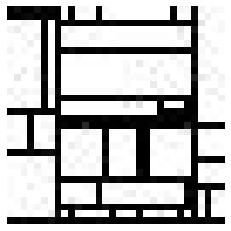

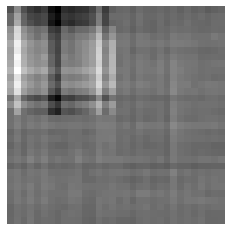

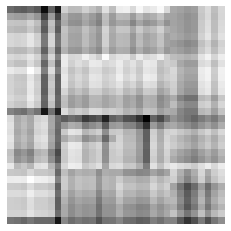

In [192]:
id = 0
img = readImage(f"img/img-{id}.jpg")
img_rp = image_rec_pad(Xpr,id,MAX_SIZE,SIZE_IMG)
img_rd = image_rec_dd(Xdr,id,D_SIZE,SIZE_IMG)

showImage(img)
showImage(img_rp)
showImage(img_rd)

# Pregunta 3 (20 puntos)
Considerando que usted quiere almacenar las $6000$ imágenes tanto para el caso de **padding** como en el caso de **domain decomposition**, y que para almacenar las imágenes, en ambos casos, de forma comprimida usted no almacenará las imágenes reconstruidas, sino que almacenará los vectores singulares correspondientes, el vector de medias $\mu$ y la matriz de coeficientes, de tal manera que si usted necesita reconstruir una imagen lo puede hacer con los procedimientos desarrollados anteriormente. Explique para ambos casos:
1. La relación entre calidad de la imagen reconstruida y uso de memoria, y
2. determine cuál de los 2 procedimientos entrega mejores resultados considerando que se quiere ahorrar por lo menos un $50\%$ de espacio de almacenamiento respecto a almacenar las $6000$ imágenes sin comprimir de alguna forma.

Justifique claramente sus respuestas.

**---------------------------------------------------------------------------------------------------------------------------**

**Respuesta:**

1.

En padding, al agregar ceros se corre el riesgo de que se pierda informacion de la imagen original, lo que se puede ver en la calidad de imagen al reconstruirla que se ve distoricionada. Sin embargo, el uso de memoria es eficiente ya que rellenar con ceros no implica una ocupacion grande de memoria
En domain decomposition, se al usar SVD/PCA para guardar la imagen en bloques mas pequeños se conserva de mejor manera la calidad de los datos, como se puede ver en la reconstruccion donde la imagen es mas nitida y similar a la original. Sin embargo, el uso de memoria puede ser grande ya que se tienen que almacenar mas matrices de coeficientes que vendrian siendo las sub matrices de cada imagen.

2.

Si el objetivo es ahorrar espacio de almacenamiento se deberia usar el metodo de padding ya que almacena menos matrices. Sin embargo se recuperara una peor imagen en comparacion a domain decomposition

**---------------------------------------------------------------------------------------------------------------------------**

**¡Ya ha llegado al final de la tarea número 2! Ahora debe enviarla antes de las 23:59 hrs. del viernes 26 de mayo!**